In [1]:
import torch

from reggae.utilities import save, load

from reggae.gp.variational.models import NonLinearLFM
from reggae.gp.variational.trainer import Trainer
from reggae.data_loaders import load_humanp53, DataHolder, scaled_barenco_data
from reggae.plot.variational_plotters import Plotter
from matplotlib import pyplot as plt

import numpy as np

f64 = np.float64

torch.Size([22, 13])


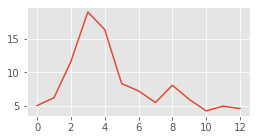

In [2]:
target_genes = [
    'KAZN','PMAIP1','PRKAB1','CSNK1G1','E2F7','SLC30A1',
    'PTP4A1','RAP2B','SUSD6','UBR5-AS1','RNF19B','AEN','ZNF79','XPC',
    'FAM212B','SESN2','DCP1B','MDM2','GADD45A','SESN1','CDKN1A','BTG2'
]
known_target_genes = [
    'CDKN1A', #p21
    'SESN1', #hPA26
    'DDB2',
    'TNFRSF10B',
    'BIK',
]

m_observed, f_observed, t = load_humanp53('../data/', target_genes)

replicate = 0

m_df, m_observed = m_observed
f_df, f_observed = f_observed
# Shape of m_observed = (replicates, genes, times)
m_observed = torch.tensor(m_observed)[replicate]

print(m_observed.shape)

num_genes = m_observed.shape[0]
num_tfs = 1
t_inducing = torch.linspace(f64(0), f64(1), 5, dtype=torch.float64).reshape((-1, 1))
t_observed = torch.linspace(f64(0), f64(1), 13, dtype=torch.float64)
plt.figure(figsize=(4, 2))
plt.plot(m_observed[4])

In [3]:

def plot_genes(rtol=1e-4, atol=1e-6):
    t_predict = torch.linspace(f64(0), f64(1), 80)
    initial_value = torch.zeros((num_genes, 1), dtype=torch.float64) #, dtype=torch.float64

    # output_obs, _ = model(t_observed.view(-1), initial_value, rtol=rtol, atol=atol)
    # output_obs = torch.squeeze(output_obs).detach()
    # plt.plot(t_observed, output_obs[0])
    # plt.scatter(t_observed, m_observed[0][0])

    outputs, _ = model(t_predict.view(-1), initial_value, rtol=rtol, atol=atol, num_samples=1)

    outputs = torch.squeeze(outputs)
    print(outputs.shape)
    plt.figure(figsize=(5, 1.4 * num_genes))
    for i in range(num_genes):
        plt.subplot(num_genes, 1, 1+i)
        plt.plot(t_predict, torch.squeeze(outputs[i]).detach())
        plt.scatter(t_observed, m_observed[i])


In [4]:
model = NonLinearLFM(num_genes, num_tfs, t_inducing, t_observed, fixed_variance=None)
optimizer = torch.optim.Adam(model.parameters(), lr=0.2)
trainer = Trainer(model, optimizer, (t_observed, m_observed))

# list(model.parameters())
print(t_observed.shape, m_observed.shape)

torch.Size([13]) torch.Size([22, 13])


C:\Users\Jacob\Documents\proj\reggae\reggae\gp\variational\models.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.inducing_inputs = torch.tensor(t_inducing, requires_grad=False)


### Outputs prior to training:

torch.Size([22, 80])


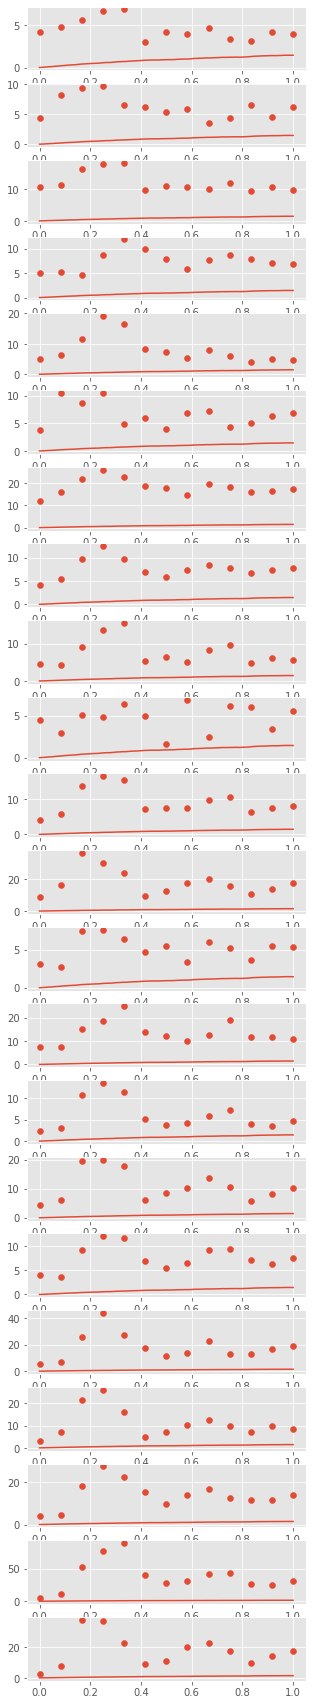

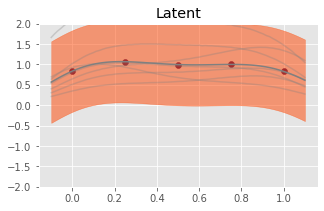

In [6]:
plotter = Plotter(model, m_df.index, t_inducing)
plot_genes(rtol=1e-3, atol=1e-4)
plotter.plot_tfs()

Epoch 1/20 - Loss: 20717.34 (20717.34 0.00) b: 1.56 d 2.49 s: 2.83 λ: 0.153
Epoch 2/20 - Loss: 21097.40 (21034.73 62.67) b: 1.42 d 2.63 s: 2.69 λ: 0.171
Epoch 3/20 - Loss: 19891.29 (19696.26 195.02) b: 1.31 d 2.75 s: 2.57 λ: 0.175
Epoch 4/20 - Loss: 19509.02 (19186.59 322.43) b: 1.23 d 2.83 s: 2.49 λ: 0.165
Epoch 5/20 - Loss: 19051.83 (18698.41 353.42) b: 1.21 d 2.86 s: 2.45 λ: 0.149
Epoch 6/20 - Loss: 18513.40 (18194.13 319.27) b: 1.23 d 2.86 s: 2.45 λ: 0.132
Epoch 7/20 - Loss: 18343.15 (18078.91 264.24) b: 1.28 d 2.83 s: 2.48 λ: 0.117
Epoch 8/20 - Loss: 17650.20 (17367.66 282.54) b: 1.35 d 2.79 s: 2.53 λ: 0.112
Epoch 9/20 - Loss: 17275.27 (16941.40 333.86) b: 1.42 d 2.74 s: 2.58 λ: 0.110
Epoch 10/20 - Loss: 17127.81 (16741.70 386.11) b: 1.48 d 2.69 s: 2.63 λ: 0.109
Epoch 11/20 - Loss: 16853.30 (16414.65 438.65) b: 1.53 d 2.67 s: 2.65 λ: 0.108
Epoch 12/20 - Loss: 16705.64 (16264.70 440.94) b: 1.55 d 2.67 s: 2.65 λ: 0.107
Epoch 13/20 - Loss: 15944.06 (15507.93 436.13) b: 1.55 d 2.69 s:

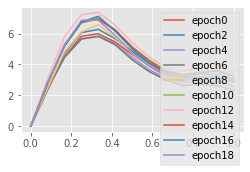

In [7]:
tol = 1e-3
# trainer = Trainer(optimizer)
output = trainer.train(20, rtol=tol, atol=tol/10, report_interval=1, plot_interval=2)

### Outputs after training

torch.Size([22, 80])


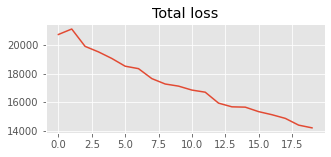

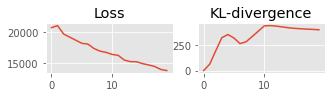

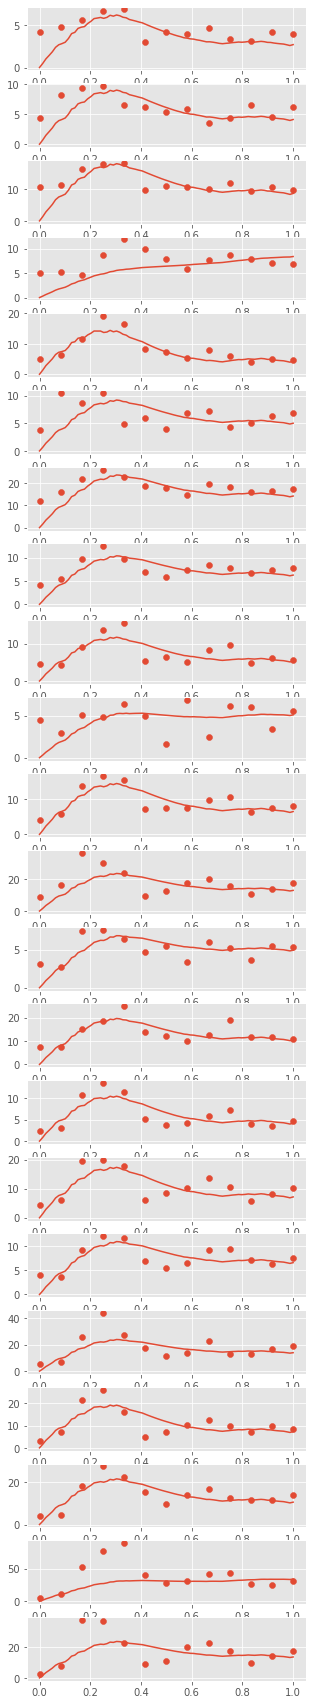

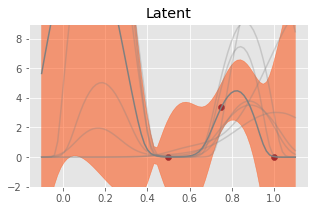

In [8]:
plotter = Plotter(model, m_df.index, t_inducing)

tol = 1e-3
plotter.plot_losses(trainer, last_x=100)
plot_genes(rtol=tol, atol=tol/10)
plotter.plot_tfs(ylim=(-2, 9))


In [9]:
save(model, 'nonlinear')

In [5]:
model = load('nonlinear', NonLinearLFM, num_genes, num_tfs, t_inducing, t_observed, fixed_variance=None)
optimizer = torch.optim.Adam(model.parameters(), lr=0.2)
trainer = Trainer(model, optimizer, (t_observed, m_observed))

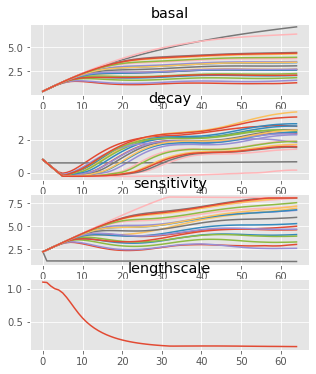

In [23]:
titles = ['basal', 'decay', 'sensitivity', 'lengthscale']
datas = [np.array(trainer.basalrates)[:,:,0],
         np.array(trainer.decayrates)[:,:,0],
         np.array(trainer.sensitivities)[:,:,0],
         np.array(trainer.lengthscales)]

plt.figure(figsize=(5, 6))
for i, (title, data) in enumerate(zip(titles, datas)):
    plt.subplot(411 + i)
    plt.title(title)
    # if data.ndim > 1:
    #     for j in range(data.shape[1]):

    plt.plot(data)

In [30]:
print(model.likelihood_variance)
print(datas[2][57:])

Parameter containing:
tensor([[5.7393, 4.8307, 4.3591, 4.2614, 4.0071, 4.5131, 1.0561, 0.1315, 1.3278,
         0.7422, 2.9644, 2.4130, 3.2269],
        [5.7577, 5.2687, 4.8372, 4.5025, 3.5202, 3.2047, 2.8984, 2.4122, 4.7849,
         3.3168, 2.9063, 4.1084, 3.3391],
        [6.0148, 5.2072, 5.0231, 4.7764, 4.5580, 3.9478, 3.6729, 3.5072, 3.4239,
         3.4435, 3.6021, 3.5029, 3.8693],
        [5.8540, 5.3677, 4.6107, 5.2272, 5.3300, 5.0251, 4.5846, 3.8361, 4.3237,
         4.5147, 4.2419, 3.8549, 3.7768],
        [5.8442, 4.6006, 4.8146, 5.0518, 4.7149, 3.6976, 3.4108, 3.8996, 3.0057,
         2.9251, 5.4471, 4.6870, 5.2233],
        [5.6721, 5.4571, 4.7240, 4.5904, 3.8189, 3.2229, 5.2106, 2.8264, 2.9011,
         4.0777, 3.4530, 3.1604, 3.4260],
        [6.0253, 5.3607, 5.1087, 4.9366, 4.5500, 4.1615, 4.0001, 3.9309, 3.8786,
         3.7600, 3.7316, 3.7103, 3.7080],
        [5.7424, 4.4875, 4.6709, 4.6263, 3.9503, 3.5860, 3.9826, 3.0480, 3.1075,
         3.0135, 3.4827, 3.4343, 3.5